# 3.3 Discontinuous Galerkin Discretizations
We are solving the scalar linear transport problem

Find $u: [0,T] \to V_D := \{ u \in L^2(\Omega), b \cdot \nabla u \in L^2(\Omega), u|_{\Gamma_{in}} = u_D\}$, s.t.
\begin{equation}
\int_{\Omega} \partial_t u v +  b \cdot \nabla u v = \int_{\Omega} f v \qquad \forall v \in V_0 = \{ u \in L^2(\Omega), b \cdot \nabla u \in L^2(\Omega), u|_{\Gamma_{in}} = 0\}
\end{equation}

In [1]:
from netgen import gui
from math import pi
from ngsolve import *

As a first example, we consider the unit square $(0,1)^2$ and the advection velocity $b = (1,2)$. Accordingly the inflow boundary is $\Gamma_{in} = \{ x \cdot y = 0\}$. 

In [2]:
from netgen.geom2d import SplineGeometry
geo = SplineGeometry()
geo.AddRectangle( (0, 0), (1, 1), 
                 bcs = ("bottom", "right", "top", "left"))
mesh = Mesh( geo.GenerateMesh(maxh=0.2))

We consider an Upwind DG discretization (in space):

Find $u: [0,T] \to V_h := \bigoplus_{T\in\mathcal{T}_h} \mathcal{P}^k(T)$ so that

$$
  \sum_{T} \int_T \partial_t u v + b \cdot \nabla u v + \int_{\partial T} b_n (\hat{u}-u) v = \int_{\Omega} f v, \quad \forall v \in V_h.
$$

Here $\hat{u}$ is the Upwind flux, i.e. $\hat{u} = u$ on the outflow boundary part $\partial T_{out} = \{ x\in \partial T \mid b(x) \cdot n_T(x) \geq 0 \}$ of $T$ and $\hat{u} = u^{other}$ else, with $u^{other}$ the value from the neighboring element.

There is quite a difference in the computational costs (compared to a standard DG formulation) depending on the question if the solution of linear systems is involved or only operator evaluations (explicit method). We treat both cases separately:

* Case 1: Solution of the time-dependent problem by explicit time stepping
* Case 2: Solution of the stationary problem 

## Case 1: Explicit time stepping with a DG formulation

Explicit Euler:
$$
\sum_{T} \int_T u^{n+1} v = \sum_{T} \int_T u^{n} v - \Delta t \sum_{T} \left\{ \int_T  b \cdot \nabla u v 
+ \int_{\partial T} b_n (\hat{u}-u) v \right\} - \Delta t \int_{\Omega} f v, \quad \forall v \in V_h,
$$
$$
  M u^{n+1} = M u^{n} - \Delta t C u^n + \Delta t f
$$

In our first example we set $u_0 = f = 0$.


### Computing convection applications $C u^n$
* We can define the bilinear form **without setting up a matrix** with storage. (`nonassemble=True`)
* A `BilinearForm` is allowed to be **nonlinear in the 1st argument** (for operator applications)
* For the DG formulation we require integrals on element boundaries, keyword: **`element_boundary`**
* To distinguish inflow from outflow we evaluate $b \cdot \mathbf{n}$. Here the normal $\mathbf{n}$ is available as a `specialcf`
* To make cases with `CoefficientFunctions` we use the `IfPos`-`CoefficientFunction`. **`IfPos(a,b,c)`**. `a` decides on the evaluation. If `a` is positive `b` is evaluated, otherwise `c`.
* To access the **neighbor** function we can use `u.Other()`
* To incorporate **boundary conditions** ($\hat{u}$ on inflow boundaries), we can use the argument `bnd` of `.Other(bnd)`. If there is no neighbor element (boundary!) the `CoefficientFunction` `bnd` is evaluated. 

In [3]:
b = CoefficientFunction((1,2))
n = specialcf.normal(mesh.dim)
ubnd = IfPos(x,1,0)

V = L2(mesh,order=2)
u,v = V.TrialFunction(), V.TestFunction()

c = BilinearForm(V, nonassemble=True)
c += b * grad(u) * v * dx
c += IfPos( (b*n), 0, (b*n) * (u.Other(ubnd)-u)) * v * dx(element_boundary=True)

gfu_expl = GridFunction(V)
Draw(gfu_expl,mesh,"u_explicit")

res = gfu_expl.vec.CreateVector()
#Operator application (equivalent to assemble and mult but faster)
res.data = c.mat * gfu_expl.vec 

### Solving mass matrix problems

* Need to invert the mass matrix
* For DG methods the mass matrix is block diagonal, often even diagonal.
* FESpace offers (if available):
  * `Mass(rho)`: mass matrix as an operator  (not a sparse matrix)
  * `Mass(rho).Inverse()`: inverse mass matrix as an operator (not a sparse matrix)

In [4]:
t = 0
dt = 0.001
tend = 1

invm = V.Mass(1).Inverse()

while t < tend-0.5*dt:
    res.data = invm @ c.mat * gfu_expl.vec     
    gfu_expl.vec.data -= dt * res
    t += dt
    Redraw(blocking=True)

## Case 2: Solving linear systems with a DG formulation

When it comes to solving linear systems with a DG formulation we have to change the way the sparsity pattern is typically constructed.

### Sparsity patterns in NGSolve
* sparsity pattern of a standard FEM and DG matrix is different
* In `NGSolve` the sparsity pattern is set up whenever a `BilinearForm` is assembled
* the sparsity pattern is based on the finite element space only (and not the integrators!).

Two cases:
 * standard FEM formulation (element-based couplings only)
 * DG formulations (element- and facet-based couplings) (`dgjumps=True`)

#### 1. Standard formulation
* In a standard formulation unknowns only have a nonzero entry if the support of corresponding basis functions overlap
* In `NGSolve` this sparsity pattern is obtained by allocating nonzero entries whenever two unknowns have an association with the same element.

The idea is sketched here for one dof:

dof $\to$ elements of dof = [el$_1,\dots,$el$_n$] $\to$ dofs of (el$_1$) $\cup \dots \cup$ dofs of (el$_n$).

#### 2. DG formulation ('dgjumps')
* In a DG formulation couplings (nonzero entries) are introduced also for basis functions which do not have overlapping support.
* An additional mechanism (keyword: `dgjumps`) has been introduced to determine the sparsity pattern. 
* This can be activated by adding the `dgjumps` flags to the `FESpace`. 
* We do not need the flag if we do not set up matrices (explicit time ste
pping).
* A `dgjumps`-formulation introduced additional couplings through facets, i.e. for all dofs that associate to the same facet a nonzero entry is reserved.

The idea is sketched here for one dof:

dof $\to$ facets of dof = [fac$_1,\dots,$fac$_n$] $\to$ dofs of (fac$_1$) $\cup \dots \cup$ dofs of (fac$_n$).

Note that 'dofs of facet $F$' is always larger than 'dofs of element $T$' if $F \subset \partial T$.

We want to demonstrate the difference in the sparsity pattern with a simple comparison in the next block

In [5]:
try:
    V1 = L2(mesh,order=0)
    a1 = BilinearForm(V1)
    a1.Assemble()

    V2 = L2(mesh,order=0, dgjumps=True)
    a2 = BilinearForm(V2)
    a2.Assemble()

    import scipy.sparse as sp
    import matplotlib.pylab as plt
    plt.rcParams['figure.figsize'] = (12, 12)

    a1.mat.AsVector()[:] = 1 # set every entry to 1
    rows,cols,vals = a1.mat.COO()
    A1 = sp.csr_matrix((vals,(rows,cols)))
    a2.mat.AsVector()[:] = 1 # set every entry to 1
    rows,cols,vals = a2.mat.COO()
    A2 = sp.csr_matrix((vals,(rows,cols)))
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.spy(A1)
    ax2.spy(A2)
except ImportError:
    pass

#### non-`dgjumps` vs `dgjumps`

In [6]:
try:
    plt.show()
except ImportError:
    pass    

* when assembling a `BilinearForm` the bilinear form has to be **linear** in both arguments again (Linearizations will be addressed later)
* `...Other(bnd=..)` does not make sense any more
* when setting up the system we require `LinearForm` and `BilinearForm`s separately to implement boundary conditions.

In [7]:
b = CoefficientFunction((1,2))
n = specialcf.normal(mesh.dim)
ubnd = IfPos(x,1,0)

V = L2(mesh,order=2, dgjumps=True)
a = BilinearForm(V)
u,v = V.TrialFunction(), V.TestFunction()
a += b * grad(u) * v * dx
a += IfPos( (b*n), 0, (b*n) * (u.Other()-u)) * v * dx(element_vb=BND)
a.Assemble()

f = LinearForm(V)
f += (b*n) * IfPos( (b*n), 0, -ubnd) * v * ds(skeleton=True,definedon=mesh.Boundaries("bottom"))
f.Assemble()

In [8]:
gfu_impl = GridFunction(V)
gfu_impl.vec.data = a.mat.Inverse() * f.vec
Draw(gfu_impl,mesh,"u_implicit")

### Remarks on sparsity pattern in NGSolve

#### Remark 1: The sparsity pattern is set up a-priorily
* The sparsity pattern of a sparse matrix in NGSolve is independent of its entries (it's set up a-priorily). 
* We can have "nonzero" entries that have the value

Below we show the reserved memory for the sparse matrix and the (numerically) non-zero entries in this sparse matrix. 

(you need matplotlib/scipy for this block - but can ignore it otherwise)

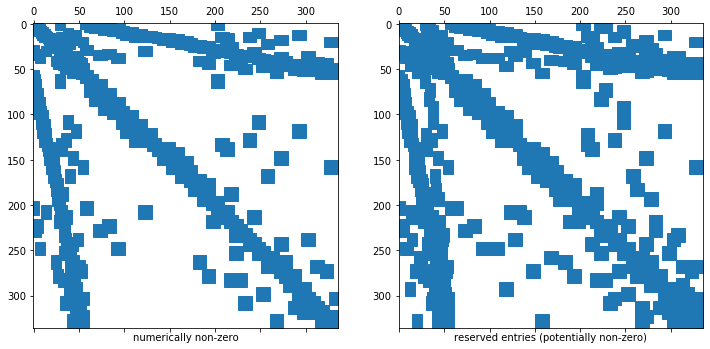

In [9]:
try:
    import scipy.sparse as sp
    import matplotlib.pylab as plt
    plt.rcParams['figure.figsize'] = (12, 12)
    rows,cols,vals = a.mat.COO()
    A1 = sp.csr_matrix((vals,(rows,cols)))
    A2 = A1.copy()
    A2.data[:] = 1
    fig = plt.figure()
    ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)
    ax1.set_xlabel("numerically non-zero")
    ax1.spy(A1)
    ax2.set_xlabel("reserved entries (potentially non-zero)")
    ax2.spy(A2)
    plt.show()
except ImportError:
    pass

#### Remark 2: Dof numbering of higher order FESpaces 

* In `NGSolve` `FESpace`s typically have a numbering where the first block of dofs corresponds to a low order subspace (which is convenient for iterative solvers). 
* For L2 this means that the first dofs correspond to the constants on elements. 

* You can turn this behavior off for some spaces, e.g. for L2 by adding the flag `all_dofs_together`.

We demonstrate this in the next comparison:


(you need matplotlib/scipy for this block - but can ignore it otherwise)

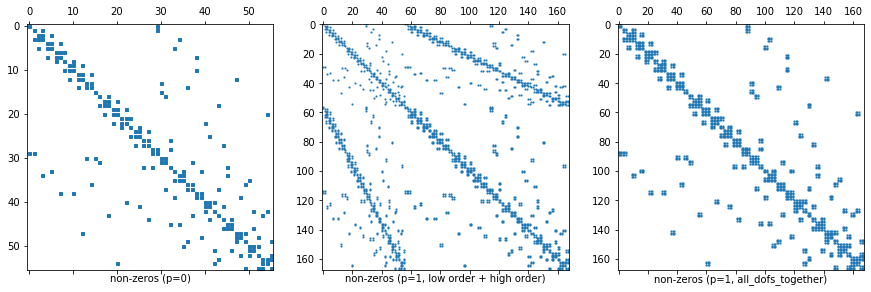

In [10]:
try:
    V0 = L2(mesh,order=0,dgjumps=True)
    a0 = BilinearForm(V0)
    a0.Assemble()

    V1 = L2(mesh,order=1,dgjumps=True)
    a1 = BilinearForm(V1)
    a1.Assemble()

    V2 = L2(mesh,order=1,dgjumps=True, all_dofs_together=True)
    a2 = BilinearForm(V2)
    a2.Assemble()

    import scipy.sparse as sp
    import matplotlib.pylab as plt
    plt.rcParams['figure.figsize'] = (15, 15)

    a0.mat.AsVector()[:] = 1 # set every entry to 1
    rows,cols,vals = a0.mat.COO()
    A0 = sp.csr_matrix((vals,(rows,cols)))
    a1.mat.AsVector()[:] = 1 # set every entry to 1
    rows,cols,vals = a1.mat.COO()
    A1 = sp.csr_matrix((vals,(rows,cols)))
    a2.mat.AsVector()[:] = 1 # set every entry to 1
    rows,cols,vals = a2.mat.COO()
    A2 = sp.csr_matrix((vals,(rows,cols)))
    fig = plt.figure()
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    ax1.set_xlabel("non-zeros (p=0)")
    ax1.spy(A0,markersize=3)
    ax2.set_xlabel("non-zeros (p=1, low order + high order)")
    ax2.spy(A1,markersize=1)
    ax3.set_xlabel("non-zeros (p=1, all_dofs_together)")
    ax3.spy(A2,markersize=1)
except ImportError:
    pass

In [11]:
try:
    plt.show()
except ImportError:
    pass

## Supplementary 1: Skeleton formulation

So far we considered the DG formulation with integrals on the boundary of each element. Instead one could formulate the problem in terms of facet integrals where every facet appears only once. 

Then, the corresponding formulation is:

Find $u: [0,T] \to V_h := \bigoplus_{T\in\mathcal{T}_h} \mathcal{P}^k(T)$ so that
$$
  \sum_{T} \int_T \partial_t u v + b \cdot \nabla u v + \sum_{F\in\mathcal{F}^{int}} \int_{F} b_n (u^{neighbor} - u) v^{downwind} + \\
  \sum_{F\in\mathcal{F}^{inflow}} \int_{F} b_n (u^{inflow}-u) v = \int_{\Omega} f v , \quad \forall v \in V_h.
$$

Here $\mathcal{F}^{int}$ is the set of interior facets and $\mathcal{F}^{inflow}$ is the set of boundary facets where $b \cdot \mathbf{n} < 0$. $v^{downwind}$ is the function on the downwind side of the facet and $u^{inflow}$ is the inflow boundary condition. 

The facet integrals are divided into interior facets and exterior (boundary) facets.
To obtain these integrals we combine the `DifferentialSymbol` `dx` or `ds` with `skeleton=True`.

In [12]:
dskel_inner  = dx(skeleton=True)
dskel_bound  = ds(skeleton=True)
# or:
dskel_inflow = ds(skeleton=True, definedon=mesh.Boundaries("left|bottom"))

In [13]:
b = CoefficientFunction((1,2))
n = specialcf.normal(mesh.dim)
ubnd = IfPos(x,1,0)

V = L2(mesh,order=2)
u,v = V.TrialFunction(), V.TestFunction()

c = BilinearForm(V)
c += b * grad(u) * v * dx


bn = b*n
vin = IfPos(bn,v.Other(),v)
c += bn*(u.Other() - u) * vin * dskel_inner
#c += IfPos(bn, 0, bn) * (u.Other(ubnd) - u) * v * dskel_bound
#alternatively:
c += bn * (u.Other(ubnd) - u) * v * dskel_inflow

gfu_expl = GridFunction(V)
Draw(gfu_expl,mesh,"u_explicit")

res = gfu_expl.vec.CreateVector()
c.Apply(gfu_expl.vec,res)

In [14]:
t = 0
dt = 0.001
tend = 1

while t < tend-0.5*dt:
    c.Apply(gfu_expl.vec,res)
    V.SolveM(res,rho=CoefficientFunction(1.0))
    gfu_expl.vec.data -= dt * res
    t += dt
    Redraw(blocking=True)

## Supplementary 2: DG for Diffusion  

DG formulation for the Poisson problem
$$\text{find: } u \in H_{0,D}^1 \quad \int_\Omega \nabla u \nabla v = \int_\Omega f v \quad \forall v \in H_{0,D}^1$$

For the non-conforming discretization we use the $L^2$ space and the (symmetric) interior penalty method:
Find $u \in V_h := \bigoplus_{T\in\mathcal{T}_h} \mathcal{P}^k(T)$ so that
\begin{align}
  & \sum_{T} \int_T \nabla u \nabla v + \sum_{F\in\mathcal{F}^{int}} \int_{F} \{\!\!\{ - \nabla u \cdot n \}\!\!\} [\![v]\!] +  \{\!\!\{ - \nabla v \cdot n \}\!\!\} [\![u]\!] +  \frac{\alpha}{h} [\![u]\!][\![v]\!] \\
  & + \sum_{F\in\mathcal{F}^{ext}} \int_{F} - \nabla u \cdot n v - \nabla v \cdot n u + \frac{\alpha}{h}~ u v = \sum_{F\in\mathcal{F}^{ext}} \int_{F} - \nabla v \cdot n u_{D} + \frac{\alpha}{h} u_{D} v  + \int_{\Omega} f v , \quad \forall v \in V_h.
\end{align}
where $\{\!\!\{\cdot\}\!\!\}$ and $[\![ \cdot ]\!]$ are the usual average and jump operators across facets.

In [15]:
n = specialcf.normal(mesh.dim)
h = specialcf.mesh_size
IfPos(x-y,0,1)
source = IfPos(x-y,5,-5)

order=2
V = L2(mesh,order=order,dgjumps=True)
a = BilinearForm(V)
u,v = V.TrialFunction(), V.TestFunction()
a += grad(u) * grad(v) * dx
def avg_flux(u):
    return 0.5*(-grad(u)*n-grad(u.Other())*n)
def jump(u):
    return u-u.Other()
alpha = 5 * order * (order+1)
a += (avg_flux(u) * jump(v) + avg_flux(v) * jump(u) + alpha/h * jump(u) * jump(v)) * dskel_inner
a += (- grad(u)*n*v - grad(v)*n*u + alpha/h * u * v) * dskel_bound
a.Assemble()

f = LinearForm(V)
f += (- grad(v)*n + alpha/h * v) * ubnd * dskel_bound
f += source * v * dx
f.Assemble()

gfu_impl = GridFunction(V)
gfu_impl.vec.data = a.mat.Inverse() * f.vec
Draw(gfu_impl,mesh,"u_implicit")